In [3]:
import sys, os, re, csv, codecs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import keras 
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D
from tensorflow.keras.models import Model
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers



Loading the train and test files

In [4]:
train = pd.read_csv('/Users/a81060586/TopicModeling/data/train.csv')
test = pd.read_csv('/Users/a81060586/TopicModeling/data/test.csv')

In [5]:
train.head()

,ID,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
0,1,Reconstructing Subject-Specific Effect Maps,Predictive models allow subject-specific inf...,1,0,0,0,0,0
1,2,Rotation Invariance Neural Network,Rotation invariance and translation invarian...,1,0,0,0,0,0
2,3,Spherical polyharmonics and Poisson kernels fo...,We introduce and develop the notion of spher...,0,0,1,0,0,0
3,4,A finite element approximation for the stochas...,The stochastic Landau--Lifshitz--Gilbert (LL...,0,0,1,0,0,0
4,5,Comparative study of Discrete Wavelet Transfor...,Fourier-transform infra-red (FTIR) spectra o...,1,0,0,1,0,0


In [6]:
train['text'] = train['TITLE'] + train['ABSTRACT']
test['text'] = test['TITLE'] + test['ABSTRACT']

In [7]:
list_classes = ["Computer Science", "Physics", "Mathematics", "Statistics", "Quantitative Biology", "Quantitative Finance"]
y = train[list_classes].values
list_sentences_train = train["text"]
list_sentences_test = test["text"]



The approach that we are taking is to feed the comments into the LSTM as part of the neural network but we can't just feed the words as it is.

So this is what we are going to do:

- Tokenization - We need to break down the sentence into unique words. For eg, "I love cats and love dogs" will become ["I","love","cats","and","dogs"]
- Indexing - We put the words in a dictionary-like structure and give them an index each For eg, {1:"I",2:"love",3:"cats",4:"and",5:"dogs"}
- Index Representation- We could represent the sequence of words in the comments in the form of index, and feed this chain of index into our LSTM. For eg, [1,2,3,4,2,5]

Fortunately, Keras has made our lives so much easier. If you are using the vanilla Tensorflow, you probably need to implement your own dictionary structure and handle the indexing yourself. In Keras, all the above steps can be done in 4 lines of code. Note that we have to define the number of unique words in our dictionary when tokenizing the sentence

In [8]:
max_features = 20000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(list_sentences_train))
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)



Now, if you look at "list_tokenized_train", you will see that Keras has turned our words into index representation for us


In [9]:
list_tokenized_train[:1]

[[4599,
  1224,
  344,
  228,
  730,
  1065,
  45,
  877,
  1224,
  344,
  300,
  72,
  1411,
  1585,
  311,
  8625,
  5,
  5026,
  21,
  129,
  3,
  11952,
  21,
  300,
  22,
  19,
  839,
  26,
  36,
  900,
  356,
  83,
  98,
  538,
  517,
  8,
  1,
  1224,
  4,
  160,
  83,
  98,
  1326,
  538,
  228,
  12,
  113,
  568,
  756,
  1779,
  18,
  1,
  11952,
  21,
  124,
  356,
  300,
  9,
  816,
  65,
  160,
  300,
  20,
  22,
  19,
  65,
  6,
  229,
  1224,
  344,
  228,
  730,
  9,
  3866,
  65,
  578,
  206,
  45,
  338,
  1480,
  1128,
  4513,
  2168,
  2,
  8035,
  2268,
  6808,
  5,
  13,
  703,
  7,
  87,
  3,
  826,
  40,
  2175,
  13191,
  6,
  415,
  1224,
  344,
  4513,
  2,
  1065,
  346,
  225,
  4,
  5,
  181,
  590,
  1347,
  13191,
  709,
  1427,
  6,
  751,
  261,
  192,
  6,
  371,
  238,
  294,
  11,
  28,
  3,
  155,
  235,
  2,
  306,
  6,
  965,
  1347,
  1,
  63,
  40,
  9,
  3,
  14004,
  152,
  54,
  10,
  22,
  19,
  65,
  11,
  69,
  590,
  1347,
  5,
  3,
  

But there's still 1 problem! What if some comments are terribly long, while some are just 1 word? Wouldn't our indexed-sentence look like this:

Comment #1: [8,9,3,7,3,6,3,6,3,6,2,3,4,9]

Comment #2: [1,2]

And we have to feed a stream of data that has a consistent length(fixed number of features) isn't it?

And this is why we use "padding"! We could make the shorter sentences as long as the others by filling the shortfall by zeros.But on the other hand, we also have to trim the longer ones to the same length(maxlen) as the short ones. In this case, we have set the max length to be 200.

In [10]:
maxlen = 200
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_te = pad_sequences(list_tokenized_test, maxlen=maxlen)



How do you know what is the best "maxlen" to set? If you put it too short, you might lose some useful feature that could cost you some accuracy points down the path.If you put it too long, your LSTM cell will have to be larger to store the possible values or states.

One of the ways to go about it is to see the distribution of the number of words in sentences.


In [11]:
totalNumWords = [len(one_comment) for one_comment in list_tokenized_train]

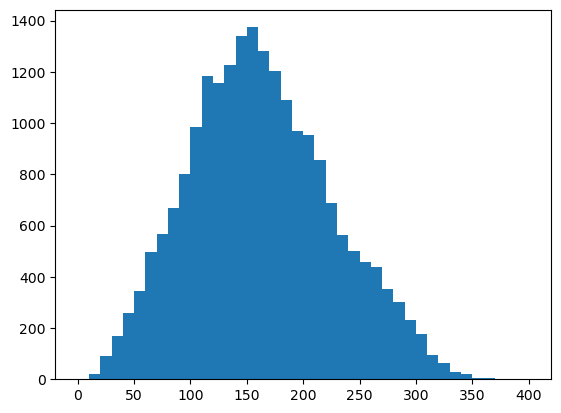

In [12]:
plt.hist(totalNumWords,bins = np.arange(0,410,10))#[0,50,100,150,200,250,300,350,400])#,450,500,550,600,650,700,750,800,850,900])
plt.show()

As we can see, most of the sentence length is about 30+. We could set the "maxlen" to about 50, but I'm being paranoid so I have set to 200. Then again, it sounds like something you could experiment and see what is the magic number.



Finally the start of building our model!

This is the architecture of the model we are trying to build. It's always to good idea to list out the dimensions of each layer in the model to think visually and help you to debug later on. 

As mentioned earlier, the inputs into our networks are our list of encoded sentences. We begin our defining an Input layer that accepts a list of sentences that has a dimension of 200.

By indicating an empty space after comma, we are telling Keras to infer the number automatically.

In [13]:
inp = Input(shape=(maxlen, )) #maxlen=200 as defined earlier

Next, we pass it to our Embedding layer, where we project the words to a defined vector space depending on the distance of the surrounding words in a sentence. Embedding allows us to reduce model size and most importantly the huge dimensions we have to deal with, in the case of using one-hot encoding to represent the words in our sentence. The output of the Embedding layer is just a list of the coordinates of the words in this vector space. For eg. (-81.012) for "cat" and (-80.012) for "dog". We could also use the distance of these coordinates to detect relevance and context. Embedding is a pretty deep topic, and if you are interested, this is a comprehensive guide: https://www.analyticsvidhya.com/blog/2017/06/word-embeddings-count-word2veec/

We need to define the size of the "vector space" we have mentioned above, and the number of unique words(max_features) we are using. Again, the embedding size is a parameter that you can tune and experiment.


In [14]:
embed_size = 128
x = Embedding(max_features, embed_size)(inp)

The embedding layer outputs a 3-D tensor of (None, 200, 128). Which is an array of sentence(None means that it's size is inferred), and for each words(200), there is an array of 128 coordinates in the vector space of embedding.

Next, we feed this Tensor into the LSTM layer. We set the LSTM to produce an output that has a dimension of 60 and want it to return the whole unrolled sequence of results. As you probably know, LSTM or RNN works by recursively feeding the output of a previous network into the input of the current network, and you would take the final output after X number of recursion. But depending on use cases, you might want to take the unrolled, or the outputs of each recursion as the result to pass to the next layer. And this is the case.



From the short line of code that defines the LSTM layer, it's easy to miss the required input dimensions. LSTM takes in a tensor of [Batch Size, Time Steps, Number of Inputs]. Batch size is the number of samples in a batch, time steps is the number of recursion it runs for each input, or it could be pictured as the number of "A"s in the above picture. Lastly, number of inputs is the number of variables(number of words in each sentence in our case) you pass into LSTM as pictured in "x" above.

We can make use of the output from the previous embedding layer which outputs a 3-D tensor of (None, 200, 128) into the LSTM layer. What it does is going through the samples, recursively run the LSTM model for 200 times, passing in the coordinates of the words each time. And because we want the unrolled version, we will receive a Tensor shape of (None, 200, 60), where 60 is the output dimension we have defined.


In [15]:
x = LSTM(60, return_sequences=True,name='lstm_layer')(x)



Before we could pass the output to a normal layer, we need to reshape the 3D tensor into a 2D one. We reshape carefully to avoid throwing away data that is important to us, and ideally we want the resulting data to be a good representative of the original data.

Therefore, we use a Global Max Pooling layer which is traditionally used in CNN problems to reduce the dimensionality of image data. In simple terms, we go through each patch of data, and we take the maximum values of each patch. These collection of maximum values will be a new set of down-sized data we can use.

As you can see from other Kaggle kernels, different variants (Average,Max,etc) of pooling layers are used for dimensionality reduction and they could yield different results so do try them out.


In [16]:
x = GlobalMaxPool1D()(x)

With a 2D Tensor in our hands, we pass it to a Dropout layer which indiscriminately "disable" some nodes so that the nodes in the next layer is forced to handle the representation of the missing data and the whole network could result in better generalization.

We set the dropout layer to drop out 10%(0.1) of the nodes.

In [17]:
x = Dropout(0.1)(x)

After a drop out layer, we connect the output of drop out layer to a densely connected layer and the output passes through a RELU function. In short, this is what it does:

Activation( (Input X Weights) + Bias)

all in 1 line, with the weights, bias and activation layer all set up for you! We have defined the Dense layer to produce a output dimension of 50.

In [18]:
x = Dense(50, activation="relu")(x)

In [19]:
x = Dropout(0.1)(x)

We feed the output into a Dropout layer again.

In [20]:
x = Dense(6, activation="sigmoid")(x)

We are almost done! All is left is to define the inputs, outputs and configure the learning process. We have set our model to optimize our loss function using Adam optimizer, define the loss function to be "binary_crossentropy" since we are tackling a binary classification. In case you are looking for the learning rate, the default is set at 0.001.

In [21]:
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])



The moment that we have been waiting for as arrived! It's finally time to put our model to the test. We'll feed in a list of 32 padded, indexed sentence for each batch and split 10% of the data as a validation set. This validation set will be used to assess whether the model has overfitted, for each batch. The model will also run for 6 epochs. These are some of the tunable parameters that you can experiment with, to see if you can push the accurate to the next level without crashing your machine(hence the batch size).


In [22]:
batch_size = 32
epochs = 6
model.fit(X_t,y, batch_size=batch_size, epochs=epochs, validation_split=0.2)

Epoch 1/6
525/525 ━━━━━━━━━━━━━━━━━━━━ 41s 76ms/step - accuracy: 0.4011 - loss: 0.4534 - val_accuracy: 0.7614 - val_loss: 0.2520
Epoch 2/6
103/525 ━━━━━━━━━━━━━━━━━━━━ 28s 67ms/step - accuracy: 0.7802 - loss: 0.2435

Additional tips and tricks

1) If you have hit some roadblocks, especially when it starts returning dimension related errors, a good idea is to run "model.summary()" because it lists out all your layer outputs, which is pretty useful for diagnosis.

In [ ]:
model.summary()